# ModelASO - Interpolador

## Unificar y convertir archivos.csv

In [3]:
import os
import csv
import pandas as pd

def convertir_a_csv_sumando_columnas(directorio):
    # Lista para almacenar los datos de todos los receptores
    datos = []

    # Iterar sobre cada archivo en el directorio
    for archivo in os.listdir(directorio):
        if archivo.endswith(".txt"):
            # Extraer las coordenadas del nombre del archivo
            partes = archivo.split('_')
            x, y, z = partes[1], partes[2], partes[3].split('.')[0]
            
            # Leer el contenido del archivo y sumar la primera y segunda columnas
            with open(os.path.join(directorio, archivo), 'r') as f:
                # Cambiar esta línea para sumar la primera y la segunda columna
                energias = [str(float(line.split()[0]) + float(line.split()[1])) for line in f if line.strip()]

            # Agregar las coordenadas y las energías sumadas a la lista de datos
            datos.append([x, y, z] + energias)

    # Nombre del archivo CSV de salida
    archivo_csv = os.path.join(directorio, "resultado_con_columnas_sumadas.csv")
    
    # Escribir los datos al archivo CSV
    with open(archivo_csv, 'w', newline='') as f:
        escritor = csv.writer(f, delimiter=';')  # Usar punto y coma como delimitador
        # Escribir el encabezado
        encabezado = ['x', 'y', 'z'] + [f'SumaEnergia{i+1}' for i in range(len(datos[0])-3)]
        escritor.writerow(encabezado)
        
        # Escribir los datos de los receptores
        for fila in datos:
            escritor.writerow(fila)

# Llamar a la función con el directorio donde se encuentran tus archivos .txt
convertir_a_csv_sumando_columnas('./Energia/')




In [4]:
ruta = './Energia/resultado_con_columnas_sumadas.csv'
df=pd.read_csv(ruta, delimiter=';')
print(df)

    x  y  z  SumaEnergia1  SumaEnergia2  SumaEnergia3  SumaEnergia4  \
0   0  0  0           0.0           0.0           0.0           0.0   
1  -1  0  1           0.0           0.0           0.0           0.0   
2   0  1  0           0.0           0.0           0.0           0.0   
3  -1 -1  1           0.0           0.0           0.0           0.0   
4   0  0 -1           0.0           0.0           0.0           0.0   
5   1  1  0           0.0           0.0           0.0           0.0   
6   0 -1  1           0.0           0.0           0.0           0.0   
7  -1  1  0           0.0           0.0           0.0           0.0   
8   0  0  1           0.0           0.0           0.0           0.0   
9   1  0  0           0.0           0.0           0.0           0.0   
10  1 -1  0           0.0           0.0           0.0           0.0   
11 -1 -1 -1           0.0           0.0           0.0           0.0   
12  1  0  1           0.0           0.0           0.0           0.0   
13  0 

## Creación del interpolador
Habrá 14 puntos en una arista del sub cubo incluidos los vertices

In [6]:
import numpy as np
from scipy.interpolate import RegularGridInterpolator
import pandas as pd

# Función que realiza la interpolación trilineal en lotes
def trilinear_interpolation_in_batches(input_csv, n, output_csv, batch_size=100):
    # Cargar los datos
    input_data = pd.read_csv(input_csv, delimiter=';')
    
    # Extraer las coordenadas y los valores de energía
    coordinates = input_data[['x', 'y', 'z']].values
    energies = input_data.filter(like='Energia').values

    # Definir los puntos de la cuadrícula
    grid_x, grid_y, grid_z = np.linspace(-1, 1, 3), np.linspace(-1, 1, 3), np.linspace(-1, 1, 3)

    # Organizar los datos de energía en una matriz 3x3x3x1000
    energy_grid = np.zeros((3, 3, 3, energies.shape[1]))
    for i, (x, y, z) in enumerate(coordinates):
        ix, iy, iz = int((x + 1) * 1), int((y + 1) * 1), int((z + 1) * 1)
        energy_grid[ix, iy, iz] = energies[i]

    # Crear la función de interpolación trilineal
    interpolating_function = RegularGridInterpolator((grid_x, grid_y, grid_z), energy_grid)

    # Calcular los nuevos puntos para la interpolación
    new_grid_x, new_grid_y, new_grid_z = np.linspace(-1, 1, n), np.linspace(-1, 1, n), np.linspace(-1, 1, n)
    xi, yi, zi = np.meshgrid(new_grid_x, new_grid_y, new_grid_z, indexing='ij')
    new_points = np.array([xi.flatten(), yi.flatten(), zi.flatten()]).T
    
    # Preparar el DataFrame de salida
    interpolated_df = pd.DataFrame(new_points, columns=['x', 'y', 'z'])
    
    # Realizar la interpolación en lotes y agregar al DataFrame de salida
    for i in range(0, energies.shape[1], batch_size):
        end_index = min(i + batch_size, energies.shape[1])
        batch = interpolating_function(new_points)[:, i:end_index]
        interpolated_df = pd.concat([interpolated_df, pd.DataFrame(batch, columns=[f'Energia{j+1}' for j in range(i, end_index)])], axis=1)
    
    # Guardar los datos interpolados en un archivo CSV
    interpolated_df.to_csv(output_csv, sep=';', index=False)
    
    return interpolated_df

# Ejemplo de uso de la función
# El siguiente código debe ser ejecutado en tu máquina local
interpolated_full_df = trilinear_interpolation_in_batches('./Energia/resultado_con_columnas_sumadas.csv', 14, 'interpolado.csv')



## Creación de la red neuronal

#### Preparación de datos para el algoritmo de red neuronal 
- Definición de grupo de entrenamiento y testeo
- Normalización

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Cargar datos
data = pd.read_csv('interpolado.csv', delimiter=';')

# Separar entradas y salidas
X = data[['x', 'y', 'z']].values
y = data.drop(['x', 'y', 'z'], axis=1).values


# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizar los datos
scaler_x = StandardScaler().fit(X_train)
scaler_y = StandardScaler().fit(y_train)
X_train_scaled = scaler_x.transform(X_train)
X_test_scaled = scaler_x.transform(X_test)
y_train_scaled = scaler_y.transform(y_train)
y_test_scaled = scaler_y.transform(y_test)


#### Configuración del modelo

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Construir el modelo
model = Sequential([
    Dense(64, activation='relu', input_shape=(3,)),
    Dense(128, activation='relu'),
    Dense(256, activation='relu'),
    Dense(1000)
    #Dense(1000, activation = 'tanh')  # Salida: 1000 valores de energía
])

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')


2025-02-07 22:46:04.191049: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-07 22:46:04.195074: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-07 22:46:04.206192: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738986364.224648   16048 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738986364.229663   16048 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/home/alejandro/Descargas/Modelos ML/modelos-ia/env/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass 

#### Entrenamiento del modelo

In [10]:
#history = model.fit(X_train_scaled, y_train_scaled, epochs=100, batch_size=32, validation_split=0.2, verbose=1)
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)


Epoch 1/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 4.3665e-04 - val_loss: 7.8511e-05
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.8326e-05 - val_loss: 3.5950e-05
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.0821e-05 - val_loss: 2.4879e-05
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.0578e-05 - val_loss: 1.9204e-05
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.6235e-05 - val_loss: 1.4895e-05
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.3762e-05 - val_loss: 1.2621e-05
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0558e-05 - val_loss: 1.0713e-05
Epoch 8/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.0276e-06 - val_loss: 8.8830e-06
Epoch 9/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.1451e-06 - val_loss: 7.5828e-06
Epoch 10/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.0647e-06 - val_loss: 6.5781e-06
Epoch 11/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.8376e-

#### Evaluación del modelo

In [11]:
loss = model.evaluate(X_test, y_test)
print(f'Test loss: {loss}')


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.3110e-07 
Test loss: 5.12536644237116e-07


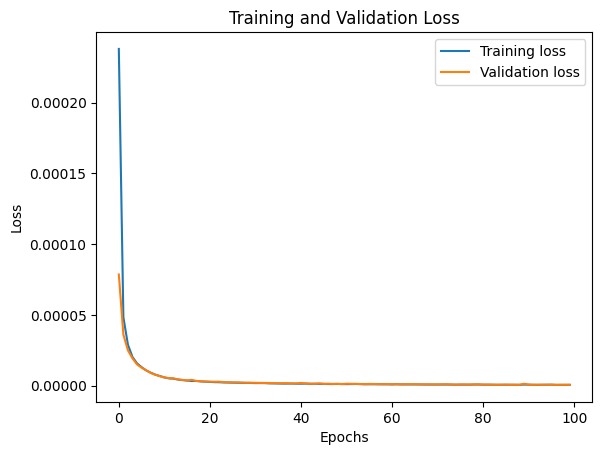

In [13]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Conclusión: No existe overfitting

#### Predicción para un punto arbitrario

In [14]:

# Ejemplo de coordenadas arbitrarias
x_arbitrario, y_arbitrario, z_arbitrario =X_test[200][0], X_test[200][1], X_test[200][2]
# Normalizar las coordenadas arbitrarias
#punto_arbitrario_scaled = scaler_x.transform([[x_arbitrario, y_arbitrario, z_arbitrario]])


In [24]:
print("Forma de y_train_scaled:", y_train_scaled.shape)
print("Forma de y_test_scaled:", y_test_scaled.shape)
print("Forma de y_train:", y_train.shape)  # Debe ser (n_samples, 1000)


Forma de y_train_scaled: (2195, 1000)
Forma de y_test_scaled: (549, 1000)
Forma de y_train: (2195, 1000)


In [27]:
punto_arbitrario = np.array([[x_arbitrario, y_arbitrario, z_arbitrario]], dtype=np.float32)
prediccion = model.predict(punto_arbitrario)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


In [28]:
# Asumiendo que tienes un DataFrame 'data' con tus datos originales o interpolados
valores_reales = data[(data['x'] == x_arbitrario) & (data['y'] == y_arbitrario) & (data['z'] == z_arbitrario)].drop(['x', 'y', 'z'], axis=1).values[0]


#### Gráfica de los primeros 200 milisegundos

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


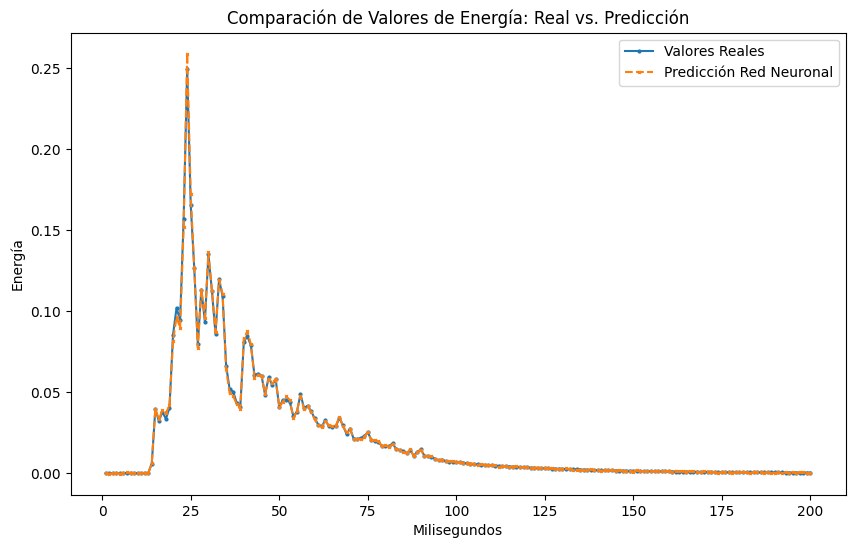

In [29]:
print(type(valores_reales))
print(type(prediccion))
plt.figure(figsize=(10, 6))
plt.plot(range(1, 201), valores_reales[:200], label='Valores Reales', marker='o', linestyle='-', markersize=2)
plt.plot(range(1, 201), prediccion[0, :200], label='Predicción Red Neuronal', marker='x', linestyle='--', markersize=2)
plt.title('Comparación de Valores de Energía: Real vs. Predicción')
plt.xlabel('Milisegundos')
plt.ylabel('Energía')
plt.legend()
plt.show()


#### Guardamos el modelo en .h5

In [30]:
model.save('modelASO.h5')